In [1]:
%%capture
! pip uninstall -y torchtext torchaudio

! pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 \
 --extra-index-url https://download.pytorch.org/whl/cu113
! pip install timm==0.6.11
! pip install fastai==2.7.9
! pip install -q kaggle

In [2]:
import numpy as np
from pathlib import Path
import os
from tqdm.notebook import tqdm
import random
import shutil
import warnings
import uuid

from PIL import Image

import torch
import torchvision
import timm
import fastai
from fastai.vision.all import *

from google.colab import files
from google.colab import drive

In [3]:
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
print(f"fastai version: {fastai.__version__}")
print(f"timm version: {timm.__version__}")

torch version: 1.12.1+cu113
torchvision version: 0.13.1+cu113
fastai version: 2.7.9
timm version: 0.6.11


In [4]:
# mount Google Drive to this notebook
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Google Drive path for saving models
BASE_DIR = Path("/content/drive/MyDrive/Reza/Projects/ml2prod")
MODELS_DIR = BASE_DIR / "models"

In [25]:
def cm_plot(learner):
    """ helper function plotting confusion matrix"""
    interp = ClassificationInterpretation.from_learner(learner)
    interp.plot_confusion_matrix(figsize=(16, 16))

## Download dataset from Kaggle

In [ ]:
# upload your kaggle.json file
files.upload()

In [7]:
# command for setting up the kaggle key
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
# download 70 Dog Breeds-Image Data Set
# https://www.kaggle.com/datasets/gpiosenka/70-dog-breedsimage-data-set
! kaggle datasets download -d gpiosenka/70-dog-breedsimage-data-set

 99% 213M/215M [00:15<00:00, 16.0MB/s]
100% 215M/215M [00:15<00:00, 14.7MB/s]


In [9]:
# remove the kaggle API token
! rm kaggle.json
! rm ~/.kaggle/kaggle.json

In [12]:
# extract images dataset into dataset/ folder
! unzip -q 70-dog-breedsimage-data-set.zip -d dataset/

## DataLoader

In [15]:
def get_dls(source, img_size, bs=64):
    image_db = DataBlock(
                blocks=(ImageBlock, CategoryBlock),
                get_items=get_image_files,
                get_y=parent_label,
                splitter=GrandparentSplitter(valid_name='test'),
                item_tfms=Resize(img_size, ResizeMethod.Squish),
                batch_tfms=[*aug_transforms(), Normalize()]
               )

    dls = image_db.dataloaders(source, bs=bs)
    return dls

In [17]:
dls = get_dls("/content/dataset", img_size=224)
print(list(dls.vocab))

['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless', 'American Spaniel', 'Basenji', 'Basset', 'Beagle', 'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim', 'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi', 'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier', 'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow', 'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote', 'Dalmation', 'Dhole', 'Dingo', 'Doberman', 'Elk Hound', 'French Bulldog', 'German Sheperd', 'Golden Retriever', 'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael', 'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor', 'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese', 'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pit Bull', 'Pomeranian', 'Poodle', 'Pug', 'Rhodesian', 'Rottweiler', 'Saint Bernard', 'Schnauzer', 'Scotch Terrier', 'Shar_Pei', 'Shiba Inu', 'Shih-Tzu', 'Siberian Husky', 'Vizsla', 'Yorkie']


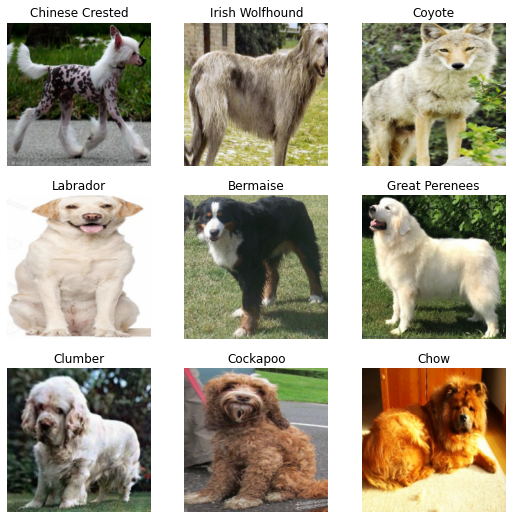

In [18]:
dls.show_batch()

## Model training

### ConvNext arch

In [19]:
model = timm.create_model('convnext_small', pretrained=True, num_classes=len(dls.vocab))
f1 = F1Score(average="macro")
convnext = Learner(dls=dls,
                   model=model,
                   loss_func=CrossEntropyLossFlat(),
                   metrics=[accuracy, f1])

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_1k_224_ema.pth


SuggestedLRs(valley=0.00019054606673307717)

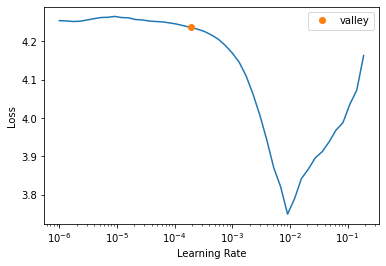

In [20]:
convnext.lr_find(start_lr=1e-6, end_lr=1, num_it=50)

In [21]:
convnext.fit_one_cycle(5, lr_max=3e-3)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.176958,0.779416,0.771429,0.754159,00:58
1,0.823590,0.573774,0.828571,0.824839,00:58
2,0.455851,0.243808,0.918571,0.918460,00:58
3,0.184059,0.173570,0.935714,0.934244,00:58
4,0.063548,0.129704,0.947143,0.946626,00:58


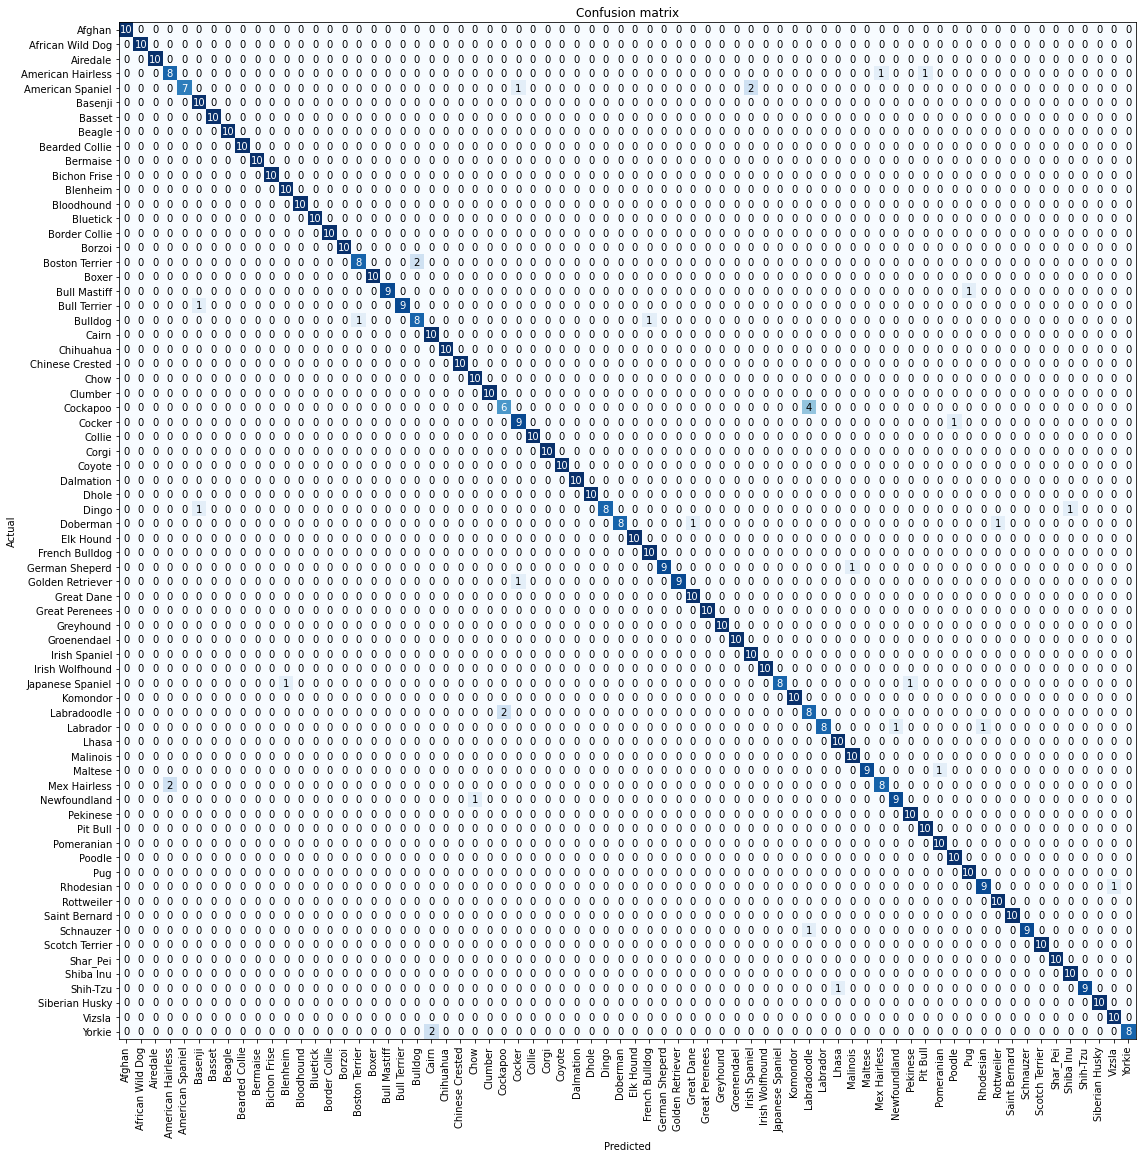

In [26]:
cm_plot(convnext)

### Swin arch

In [27]:
model2 = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=len(dls.vocab))
f1 = F1Score(average="macro")
swin = Learner(dls=dls, 
                   model=model2,
                   loss_func=CrossEntropyLossFlat(),
                   metrics=[accuracy, f1])

/usr/local/lib/python3.8/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth" to /root/.cache/torch/hub/checkpoints/swin_tiny_patch4_window7_224.pth


SuggestedLRs(valley=8.31763754831627e-05)

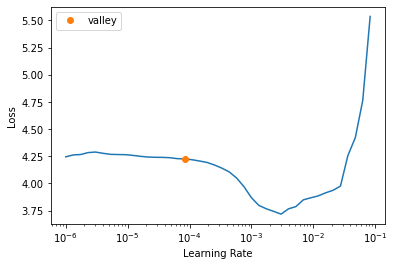

In [28]:
swin.lr_find(start_lr=1e-6, end_lr=1, num_it=50)

In [29]:
swin.fit_one_cycle(5, lr_max=7e-4)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.114861,0.699739,0.782857,0.768523,00:31
1,0.840726,0.337527,0.882857,0.878238,00:31
2,0.535760,0.246149,0.902857,0.899861,00:31
3,0.242862,0.127503,0.954286,0.953719,00:31
4,0.120405,0.111626,0.964286,0.963869,00:31


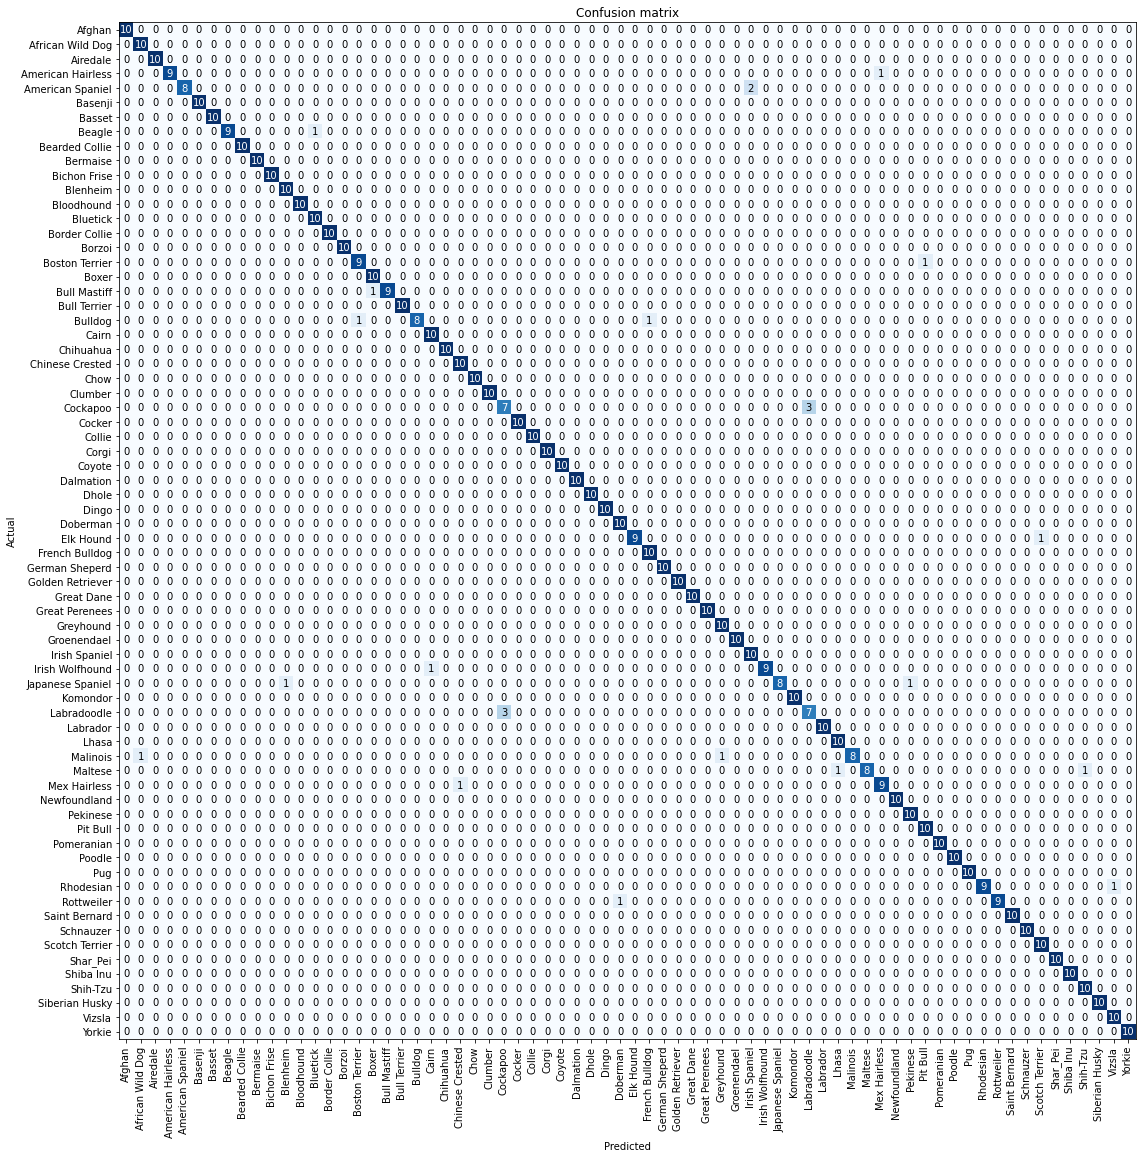

In [30]:
cm_plot(swin)

## Export the best model

In [31]:
swin.export(MODELS_DIR / "dog_breeds__swin_tiny_v1.pkl")